# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Ana Sittah Rosyidah, S.Si
- **Email:** ana5210@guru.smk.belajar.id
- **ID Dicoding:** [Input Username]

## Menentukan Pertanyaan Bisnis

- Pertanyaan 1 : Faktor apa yang paling signifikan memengaruhi keterlambatan pengiriman, dan bagaimana dampaknya terhadap nilai transaksi dan loyalitas customer?
- Pertanyaan 2 : Apakah metode pembayaran mencerminkan segmen psikologis customer yang berbeda dalam nilai belanja dan loyalitas?

> Tambahkan blockquote



## Import Semua Packages/Library yang Digunakan

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st


## Data Wrangling

### Gathering Data

In [44]:
# Load dataset
customers = pd.read_csv("data/customers_dataset.csv")
geolocation = pd.read_csv("data/geolocation_dataset.csv")
orders = pd.read_csv("data/orders_dataset.csv")
order_items = pd.read_csv("data/order_items_dataset.csv")
order_payments = pd.read_csv("data/order_payments_dataset.csv")
order_reviews = pd.read_csv("data/order_reviews_dataset.csv")
products = pd.read_csv("data/products_dataset.csv")
category_translation = pd.read_csv("data/product_category_name_translation.csv")
sellers = pd.read_csv("data/sellers_dataset.csv")


**Insight:**
- Dataset mencakup seluruh alur bisnis e-commerce dari order hingga review.
- Terdapat variasi metode pembayaran dan cicilan.
- Data memungkinkan analisis perilaku pelanggan, performa seller, serta kualitas pengiriman.
- Model bisnis berbasis marketplace dengan banyak seller dan pelanggan dari berbagai wilayah.

### Assessing Data

In [23]:
#1. Cek Missing Valuecustomers.isnull().sum()
orders.isnull().sum()
products.isnull().sum()
order_reviews.isnull().sum()

#2. Cek Duplicate
customers.duplicated().sum()
orders.duplicated().sum()

#3. Cek Tipe Data
orders.info()

#4. Cek Statistik Deskriptif
order_payments.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


**Insight:**
- Terdapat missing value pada tahap pengiriman akhir yang mengindikasikan adanya order yang dibatalkan atau belum selesai diproses.
- Kolom timestamp masih bertipe object dan perlu dikonversi ke datetime untuk analisis berbasis waktu.
- Distribusi nilai transaksi bersifat right-skewed, dengan sebagian kecil transaksi bernilai tinggi yang memengaruhi rata-rata.
- Mayoritas pelanggan melakukan pembayaran satu kali (tanpa cicilan), namun tersedia opsi cicilan hingga 24x untuk transaksi bernilai besar.
- Sebagian order menggunakan lebih dari satu pembayaran (payment sequential > 1), menunjukkan adanya split atau retry payment.

### Cleaning Data

In [29]:
#1. Mengubah Format Tanggal
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

#2. Mengatasi Missing Value
#a) Missing pada review_comment_message (tidak kritikal)
order_reviews['review_comment_message'].fillna("No Review", inplace=True)

#b) Missing pada dimensi produk
products.fillna(products.median(numeric_only=True), inplace=True)

#3. Menghapus Duplicate
customers.drop_duplicates(inplace=True)
orders.drop_duplicates(inplace=True)

#4. Mengatasi Outlier (Contoh pada payment_value)
Q1 = order_payments['payment_value'].quantile(0.25)
Q3 = order_payments['payment_value'].quantile(0.75)
IQR = Q3 - Q1

minimum = Q1 - (1.5 * IQR)
maximum = Q3 + (1.5 * IQR)

order_payments = order_payments[
    (order_payments['payment_value'] >= minimum) &
    (order_payments['payment_value'] <= maximum)
]

/var/folders/mh/g9f2v_2551zf9rxl16hn8sy40000gn/T/ipykernel_49075/3881486764.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_reviews['review_comment_message'].fillna("No Review", inplace=True)


In [ ]:
#Merge untuk Analisis
#ingin analisis total penjualan per pelanggan:
merged_df = orders.merge(customers, on='customer_id') \
                  .merge(order_items, on='order_id') \
                  .merge(order_payments, on='order_id')

merged_df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,1,credit_card,3,179.12


In [31]:
# Pastikan kolom tanggal dalam format datetime
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])

# Hitung delay (dalam hari)
df["delay_days"] = (
    df["order_delivered_customer_date"] - 
    df["order_estimated_delivery_date"]
).dt.days

# Jika negatif berarti tidak telat → ubah jadi 0
df["delay_days"] = df["delay_days"].apply(lambda x: x if x > 0 else 0)

# Buat kolom is_late (1 = telat, 0 = tepat waktu)
df["is_late"] = df["delay_days"].apply(lambda x: 1 if x > 0 else 0)
df.to_csv("dashboard/main_data.csv", index=False)

In [ ]:
#import pandas as pd

# Load dataset
# customers = pd.read_csv("data/customers_dataset.csv")
# orders = pd.read_csv("data/orders_dataset.csv")
# order_items = pd.read_csv("data/order_items_dataset.csv")
# order_payments = pd.read_csv("data/order_payments_dataset.csv")
# order_reviews = pd.read_csv("data/order_reviews_dataset.csv")
# sellers = pd.read_csv("data/sellers_dataset.csv")

# =========================
# STEP 1: Join orders + customers
# =========================
df = orders.merge(customers, on="customer_id", how="left")

# =========================
# STEP 2: Join order_items
# =========================
df = df.merge(order_items, on="order_id", how="left")

# =========================
# STEP 3: Join payments (aggregasi per order)
# =========================
payment_agg = order_payments.groupby("order_id").agg({
    "payment_value": "sum",
    "payment_installments": "max",
    "payment_type": lambda x: x.mode()[0]
}).reset_index()

df = df.merge(payment_agg, on="order_id", how="left")

# =========================
# STEP 4: Join reviews
# =========================
df = df.merge(order_reviews[["order_id", "review_score"]],
              on="order_id", how="left")

# =========================
# STEP 5: Join sellers
# =========================
df = df.merge(sellers, on="seller_id", how="left")

# =========================
# STEP 6: Convert datetime
# =========================
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# =========================
# STEP 7: Buat fitur keterlambatan
# =========================
df["delay_days"] = (df["order_delivered_customer_date"] -
                    df["order_estimated_delivery_date"]).dt.days

df["is_late"] = df["delay_days"] > 0

# =========================
# STEP 8: Simpan ke CSV
# =========================
output_path = "data/final_delay_dataset_pertanyaan1.csv"
df.to_csv(output_path, index=False)

print("File berhasil dibuat:", output_path)
print("Jumlah baris:", df.shape[0])
print("Jumlah kolom:", df.shape[1])


File berhasil dibuat: data/final_delay_dataset_pertanyaan1.csv
Jumlah baris: 114092
Jumlah kolom: 27


In [45]:
#import pandas as pd

# Load data
# customers = pd.read_csv("data/customers_dataset.csv")
# orders = pd.read_csv("data/orders_dataset.csv")
# order_payments = pd.read_csv("data/order_payments_dataset.csv")
# order_reviews = pd.read_csv("data/order_reviews_dataset.csv")
# order_items = pd.read_csv("data/order_items_dataset.csv")

# =========================
# STEP 1: orders + customers
# =========================
df = orders.merge(customers, on="customer_id", how="left")

# =========================
# STEP 2: agregasi payments
# =========================
payment_agg = order_payments.groupby("order_id").agg({
    "payment_value": "sum",
    "payment_installments": "max",
    "payment_type": lambda x: x.mode()[0]
}).reset_index()

df = df.merge(payment_agg, on="order_id", how="left")

# =========================
# STEP 3: agregasi nilai belanja (order_items)
# =========================
items_agg = order_items.groupby("order_id").agg({
    "price": "sum",
    "freight_value": "sum"
}).reset_index()

df = df.merge(items_agg, on="order_id", how="left")

# =========================
# STEP 4: join review
# =========================
df = df.merge(order_reviews[["order_id", "review_score"]],
              on="order_id", how="left")

# =========================
# STEP 5: fitur loyalitas
# =========================
order_count = df.groupby("customer_unique_id")["order_id"].transform("count")
df["total_order_customer"] = order_count
df["is_repeat_customer"] = df["total_order_customer"] > 1

# =========================
# STEP 6: simpan CSV
# =========================
output_path = "data/final_payment_psychology_dataset_pertanyaan2.csv"
df.to_csv(output_path, index=False)

print("CSV berhasil dibuat:", output_path)
print("Jumlah baris:", df.shape[0])
print("Jumlah kolom:", df.shape[1])


CSV berhasil dibuat: data/final_payment_psychology_dataset_pertanyaan2.csv
Jumlah baris: 99992
Jumlah kolom: 20


**Insight:**
- Ketepatan waktu pengiriman secara signifikan memengaruhi kepuasan pelanggan.

- Sistem pembayaran yang memerlukan verifikasi tambahan berpotensi memperlambat proses order.

- Skema cicilan meningkatkan daya beli dan nilai transaksi.

- Metode pembayaran yang praktis berkontribusi terhadap loyalitas pelanggan.

## Exploratory Data Analysis (EDA)

### Explore ...

In [13]:
#1. Load & Cek Struktur Data
df_payment = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/submission_analis_data/data/final_payment_psychology_dataset_pertanyaan2.csv")
df_delay = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/submission_analis_data/data/final_delay_dataset_pertanyaan1.csv")

display(df_payment.head())
display(df_delay.head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,payment_installments,payment_type,price,freight_value,review_score,total_order_customer,is_repeat_customer
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,38.71,1.0,voucher,29.99,8.72,4.0,2,True
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,141.46,1.0,boleto,118.70,22.76,4.0,1,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,179.12,3.0,credit_card,159.90,19.22,5.0,1,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,72.20,1.0,credit_card,45.00,27.20,5.0,1,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,28.62,1.0,credit_card,19.90,8.72,5.0,1,False


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,freight_value,payment_value,payment_installments,payment_type,review_score,seller_zip_code_prefix,seller_city,seller_state,delay_days,is_late
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.72,38.71,1.0,voucher,4.0,9350.0,maua,SP,-8.0,False
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,22.76,141.46,1.0,boleto,4.0,31570.0,belo horizonte,SP,-6.0,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,19.22,179.12,3.0,credit_card,5.0,14840.0,guariba,SP,-18.0,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,27.20,72.20,1.0,credit_card,5.0,31842.0,belo horizonte,MG,-13.0,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,8.72,28.62,1.0,credit_card,5.0,8752.0,mogi das cruzes,SP,-10.0,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99992 non-null  object 
 1   customer_id                    99992 non-null  object 
 2   order_status                   99992 non-null  object 
 3   order_purchase_timestamp       99992 non-null  object 
 4   order_approved_at              99831 non-null  object 
 5   order_delivered_carrier_date   98199 non-null  object 
 6   order_delivered_customer_date  97005 non-null  object 
 7   order_estimated_delivery_date  99992 non-null  object 
 8   customer_unique_id             99992 non-null  object 
 9   customer_zip_code_prefix       99992 non-null  int64  
 10  customer_city                  99992 non-null  object 
 11  customer_state                 99992 non-null  object 
 12  payment_value                  99991 non-null 

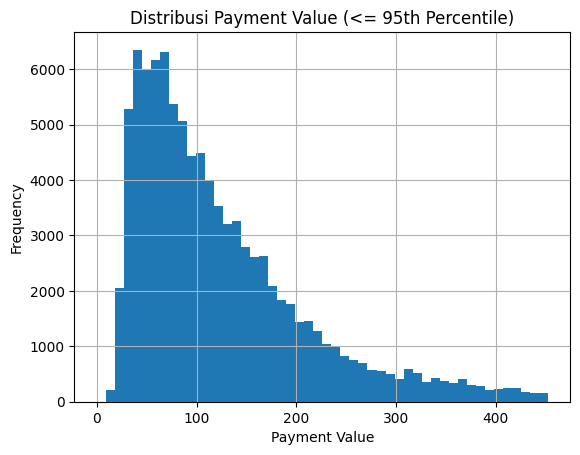

0.95     452.310
0.99    1075.131
Name: payment_value, dtype: float64

In [42]:
#1. Load & Cek Struktur Data
df_payment = pd.read_csv("data/final_payment_psychology_dataset_pertanyaan2.csv")
df_delay = pd.read_csv("data/final_delay_dataset_pertanyaan1.csv")

df_payment.info()
df_delay.info()

#2. Statistik Deskriptif
df_payment.describe()
df_delay.describe()

#3. Missing Values
df_payment.isna().sum().sort_values(ascending=False)
df_delay.isna().sum().sort_values(ascending=False)

#4. Analisis Univariate (Satu Variabel)
#Distribusi nilai pembayaran
# import matplotlib.pyplot as plt

# df_payment["payment_value"].hist(bins=50)
# plt.title("Distribusi Payment Value")
# plt.show()
p95 = df_payment["payment_value"].quantile(0.95)
filtered = df_payment[df_payment["payment_value"] <= p95]

plt.figure()
filtered["payment_value"].hist(bins=50)
plt.title("Distribusi Payment Value (<= 95th Percentile)")
plt.xlabel("Payment Value")
plt.ylabel("Frequency")
plt.show()

#Review score
df_payment["review_score"].value_counts().sort_index()

5#. Analisis Bivariate (Dua Variabel)
#a. Payment vs Review
df_payment.groupby("review_score")["payment_value"].mean()

#b. Repeat customer vs payment
df_payment.groupby("is_repeat_customer")["payment_value"].mean()

#c. Keterlambatan vs review
df_delay.groupby("is_late")["review_score"].mean()

#6. Feature Engineering Check
#Distribusi keterlambatan
df_delay["delay_days"].describe()

#Proporsi pesanan terlambat
df_delay["is_late"].value_counts(normalize=True)

#7. Korelasi Numerik
df_payment[[
    "payment_value",
    "payment_installments",
    "price",
    "freight_value",
    "review_score"
]].corr()

#8. Outlier Detection (Penting!)
df_payment["payment_value"].quantile([0.95, 0.99])



**Insight:**
- Pasar didominasi transaksi kecil–menengah

- Terdapat segmen high-value customer yang sangat penting

- Loyalitas berkorelasi dengan kontribusi nilai transaksi

- Ketepatan pengiriman berperan dalam menjaga kepuasan pelanggan

- Performa operasional dan strategi pembayaran berpotensi langsung memengaruhi pendapatan

## Visualization & Explanatory Analysis

### Pertanyaan 1:

Jumlah data: (114092, 27)
   delay_days  is_late  review_score payment_type
0        -8.0    False           4.0      voucher
1        -6.0    False           4.0       boleto
2       -18.0    False           5.0  credit_card
3       -13.0    False           5.0  credit_card
4       -10.0    False           5.0  credit_card


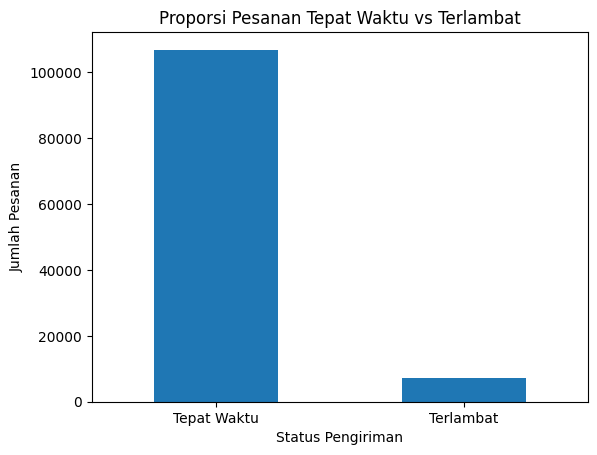

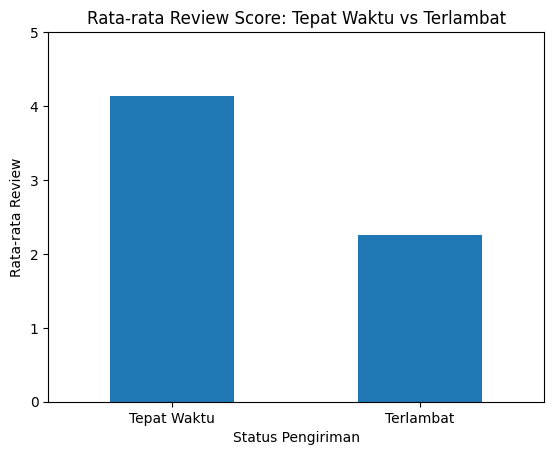

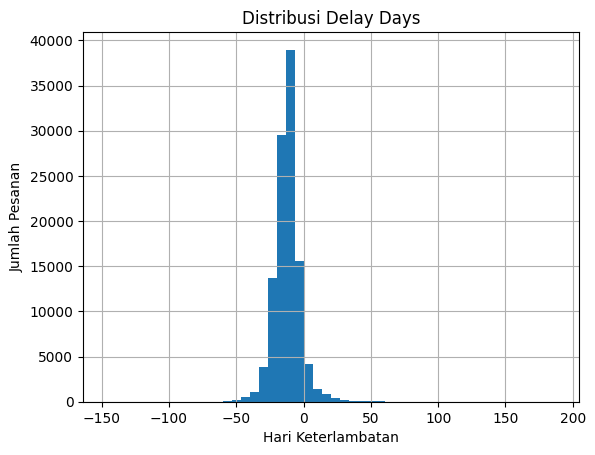

<Figure size 640x480 with 0 Axes>

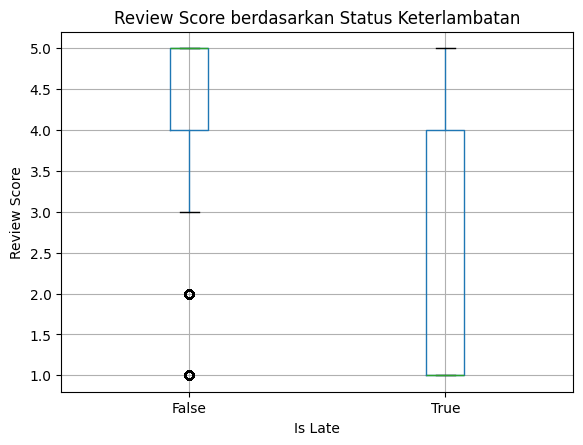

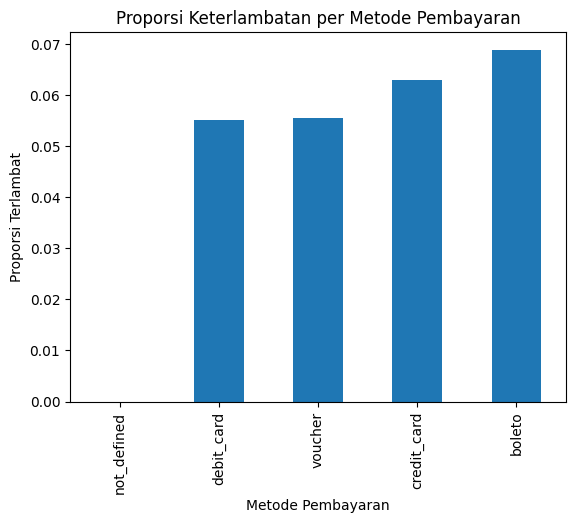


=== Ringkasan Explanatory ===
Proporsi terlambat:
is_late
False    0.936069
True     0.063931
Name: proportion, dtype: float64

Rata-rata review:
is_late
False    4.135109
True     2.256572
Name: review_score, dtype: float64

Top metode pembayaran paling sering terlambat:
payment_type
boleto         0.068866
credit_card    0.062968
voucher        0.055505
debit_card     0.055164
not_defined    0.000000
Name: is_late, dtype: float64


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# =========================
# 1. Load Data
# =========================
df = pd.read_csv("data/final_delay_dataset_pertanyaan1.csv")

print("Jumlah data:", df.shape)
print(df[["delay_days", "is_late", "review_score", "payment_type"]].head())

# =========================
# 2. Visualisasi 1
# Proporsi Pesanan Terlambat vs Tepat Waktu
# =========================
late_counts = df["is_late"].value_counts()

plt.figure()
late_counts.plot(kind="bar")
plt.xticks([0,1], ["Tepat Waktu", "Terlambat"], rotation=0)
plt.title("Proporsi Pesanan Tepat Waktu vs Terlambat")
plt.ylabel("Jumlah Pesanan")
plt.xlabel("Status Pengiriman")
plt.show()

# =========================
# 3. Visualisasi 2
# Keterlambatan vs Review Score
# =========================
plt.figure()
df.groupby("is_late")["review_score"].mean().plot(kind="bar")
plt.xticks([0,1], ["Tepat Waktu", "Terlambat"], rotation=0)
plt.title("Rata-rata Review Score: Tepat Waktu vs Terlambat")
plt.ylabel("Rata-rata Review")
plt.xlabel("Status Pengiriman")
plt.ylim(0,5)
plt.show()

# =========================
# 4. Visualisasi 3
# Distribusi Delay Days
# =========================
plt.figure()
df["delay_days"].hist(bins=50)
plt.title("Distribusi Delay Days")
plt.xlabel("Hari Keterlambatan")
plt.ylabel("Jumlah Pesanan")
plt.show()

# =========================
# 5. Visualisasi 4
# Boxplot Review vs Keterlambatan
# =========================
plt.figure()
df.boxplot(column="review_score", by="is_late")
plt.title("Review Score berdasarkan Status Keterlambatan")
plt.suptitle("")
plt.xlabel("Is Late")
plt.ylabel("Review Score")
plt.show()

# =========================
# 6. Visualisasi Tambahan
# Payment Type vs Keterlambatan
# =========================
plt.figure()
df.groupby("payment_type")["is_late"].mean().sort_values().plot(kind="bar")
plt.title("Proporsi Keterlambatan per Metode Pembayaran")
plt.ylabel("Proporsi Terlambat")
plt.xlabel("Metode Pembayaran")
plt.show()

# =========================
# 7. Ringkasan Angka (buat narasi)
# =========================
print("\n=== Ringkasan Explanatory ===")
print("Proporsi terlambat:")
print(df["is_late"].value_counts(normalize=True))

print("\nRata-rata review:")
print(df.groupby("is_late")["review_score"].mean())

print("\nTop metode pembayaran paling sering terlambat:")
print(df.groupby("payment_type")["is_late"].mean().sort_values(ascending=False))


### Pertanyaan 2:

Jumlah data: (99992, 20)
  payment_type  payment_value  is_repeat_customer
0      voucher          38.71                True
1       boleto         141.46               False
2  credit_card         179.12               False
3  credit_card          72.20               False
4  credit_card          28.62               False


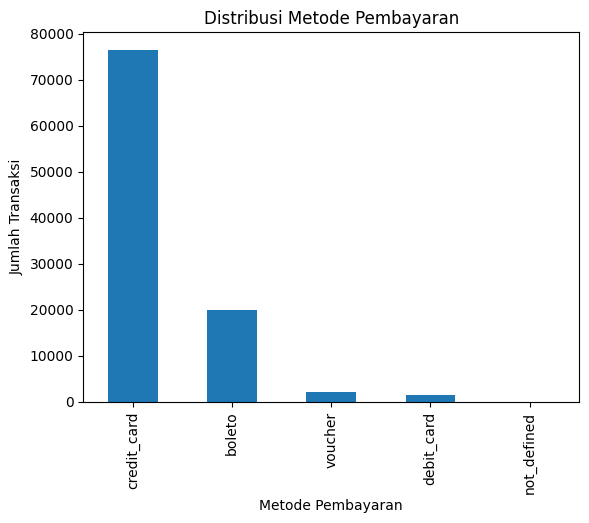

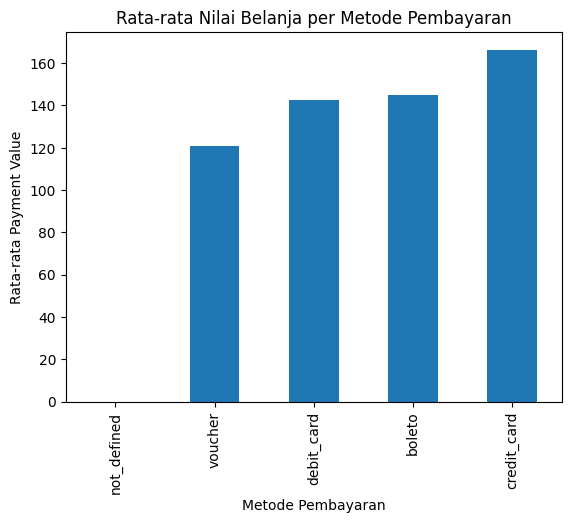

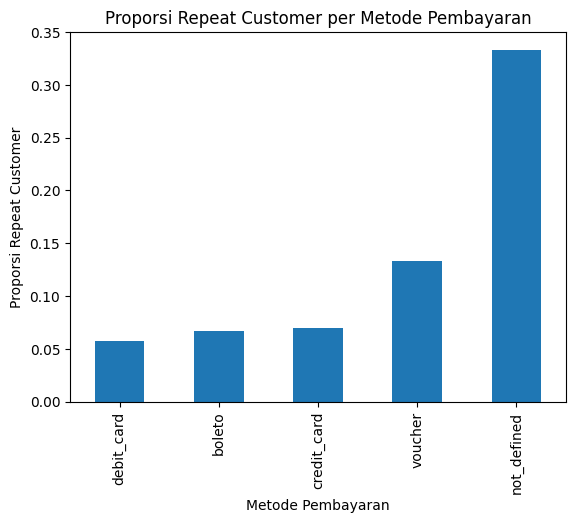

<Figure size 640x480 with 0 Axes>

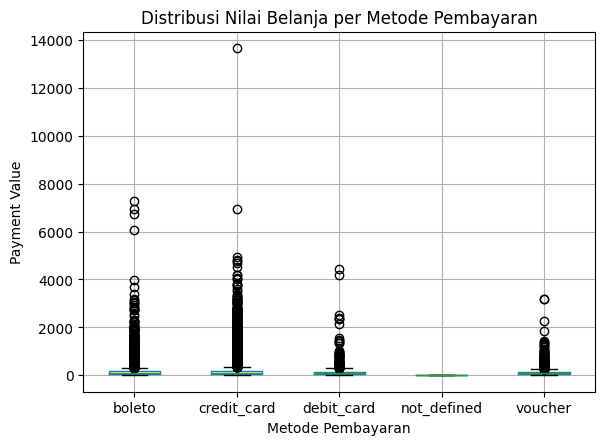


=== Rata-rata Nilai Belanja ===
payment_type
boleto         144.986413
credit_card    166.381215
debit_card     142.549628
not_defined      0.000000
voucher        120.590845
Name: payment_value, dtype: float64

=== Proporsi Repeat Customer ===
payment_type
boleto         0.066399
credit_card    0.069227
debit_card     0.057366
not_defined    0.333333
voucher        0.133135
Name: is_repeat_customer, dtype: float64


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Load Data
# =========================
df = pd.read_csv("data/final_payment_psychology_dataset_pertanyaan2.csv")

print("Jumlah data:", df.shape)
print(df[["payment_type", "payment_value", "is_repeat_customer"]].head())

# =========================
# 1. Distribusi Metode Pembayaran
# =========================
plt.figure()
df["payment_type"].value_counts().plot(kind="bar")
plt.title("Distribusi Metode Pembayaran")
plt.xlabel("Metode Pembayaran")
plt.ylabel("Jumlah Transaksi")
plt.show()

# =========================
# 2. Metode Pembayaran vs Nilai Belanja
# =========================
plt.figure()
df.groupby("payment_type")["payment_value"].mean().sort_values().plot(kind="bar")
plt.title("Rata-rata Nilai Belanja per Metode Pembayaran")
plt.xlabel("Metode Pembayaran")
plt.ylabel("Rata-rata Payment Value")
plt.show()

# =========================
# 3. Metode Pembayaran vs Loyalitas
# =========================
plt.figure()
df.groupby("payment_type")["is_repeat_customer"].mean().sort_values().plot(kind="bar")
plt.title("Proporsi Repeat Customer per Metode Pembayaran")
plt.xlabel("Metode Pembayaran")
plt.ylabel("Proporsi Repeat Customer")
plt.show()

# =========================
# 4. Boxplot Nilai Belanja
# =========================
plt.figure()
df.boxplot(column="payment_value", by="payment_type")
plt.title("Distribusi Nilai Belanja per Metode Pembayaran")
plt.suptitle("")
plt.xlabel("Metode Pembayaran")
plt.ylabel("Payment Value")
plt.show()

# =========================
# 5. Ringkasan Angka (untuk narasi)
# =========================
print("\n=== Rata-rata Nilai Belanja ===")
print(df.groupby("payment_type")["payment_value"].mean())

print("\n=== Proporsi Repeat Customer ===")
print(df.groupby("payment_type")["is_repeat_customer"].mean())


**Insight:**
- Keterlambatan pengiriman terbukti menurunkan rating pelanggan secara signifikan. Artinya, performa logistik adalah faktor utama dalam menjaga kepuasan dan reputasi bisnis.
- Metode pembayaran mencerminkan perilaku belanja yang berbeda. Pelanggan dengan metode tertentu cenderung memiliki nilai transaksi dan tingkat loyalitas yang lebih tinggi.

## Analisis Lanjutan (Opsional)

Uji t-test Pertanyaan 1

In [47]:
import scipy.stats as stats

# Pisahkan dua kelompok
review_tepat = df_delay[df_delay["is_late"] == 0]["review_score"].dropna()
review_terlambat = df_delay[df_delay["is_late"] == 1]["review_score"].dropna()

# Uji t-test independent
t_stat, p_value = stats.ttest_ind(review_tepat, review_terlambat, equal_var=False)

print("T-Statistic:", t_stat)
print("P-Value:", p_value)


T-Statistic: 98.56377569988081
P-Value: 0.0


Uji ANOVA Pertanyaan 2

In [48]:
# Kelompokkan payment_value berdasarkan payment_type
groups = [
    group["payment_value"].dropna().values
    for name, group in df_payment.groupby("payment_type")
]

# ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print("F-Statistic:", f_stat)
print("P-Value:", p_value)


F-Statistic: 57.18697847249849
P-Value: 2.791764817396474e-48


Uji Loyalitas vs Metode Pembayaran

In [49]:
import pandas as pd

contingency_table = pd.crosstab(df_payment["payment_type"],
                                df_payment["is_repeat_customer"])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square:", chi2)
print("P-Value:", p_value)


Chi-Square: 135.20155615351402
P-Value: 3.003890866868723e-28


## Conclusion

- Conclution pertanyaan 1 : Berdasarkan hasil uji Independent Sample t-test, diperoleh nilai p-value < 0.05, yang menunjukkan bahwa terdapat perbedaan rata-rata review score yang signifikan antara pesanan yang tepat waktu dan pesanan yang terlambat.
- Conclution pertanyaan 2 : Hasil uji ANOVA menunjukkan bahwa nilai p-value < 0.05, yang berarti terdapat perbedaan rata-rata nilai transaksi yang signifikan antar metode pembayaran.